# Quantum Phase Estimation

Below we will implement Quantum Phase Estimation algorithm, as described in Chapter II.5.2 of Nielsen & Chuang "Quantum Computation and Quantum Informtaion".


### Problem

For simplicity we will consder particular case |u> = |1>.

We are given single-qubit gate

$$\begin{pmatrix}
   * & 0 \\
   0 & e^{2 \pi i \phi}
  \end{pmatrix},
$$

where $\phi \in [0, 1]$.

Task is to estimate $\phi$.

In [130]:
import cirq
import numpy as np

def estimate_phase(U, n_bits=8, n_repeats=5, print_circuit=False):
    ct = cirq.Circuit()
    qubits = cirq.LineQubit.range(n_bits+1) 
    for q in qubits[0:n_bits]:
        ct.append(cirq.H.on(q))
    ct.append(cirq.X.on(qubits[-1]))
    
    for i in range(n_bits-1, -1, -1):
        power = 2**(n_bits-1-i)
        ct.append((U**power).on(qubits[-1]).controlled_by(qubits[i]))
    ct.append(cirq.QFT(*qubits[:-1])**-1)
    ct.append(cirq.measure(*qubits[:-1], key='m'))
    
    if print_circuit:
        print(ct)
    
    sim = cirq.Simulator()
    results = []
    for _ in range(n_repeats):
        measuerement_result = sim.simulate(ct).measurements['m']
        phase = sum(measuerement_result[i] * 2**(n_bits-1-i) for i in range(n_bits))/(2**n_bits)
        results.append(phase)
    return np.mean(results)

In [131]:
estimate_phase(cirq.T, n_bits=3, print_circuit=True)

0: ───H───────────@───QFT^-1───M('m')───
                  │   │        │
1: ───H───────@───┼───#2───────M────────
              │   │   │        │
2: ───H───@───┼───┼───#3───────M────────
          │   │   │
3: ───X───T───S───Z─────────────────────


0.125

Let's test it, using Rz gate:

$$Rz(4 \pi \phi) =\begin{pmatrix}
   e^{-2 \pi i \phi} & 0 \\
   0 & e^{2 \pi i \phi}
  \end{pmatrix}.
$$

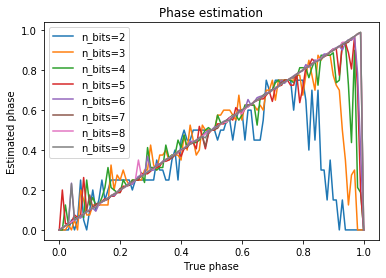

In [129]:
from matplotlib import pyplot as plt

for n_bits in range(3, 8):
    phi_range = np.linspace(0, 1.0, 51)
    phi_est = []
    for phi in phi_range:
        phi_est.append(estimate_phase(cirq.Rz(phi * 4 * np.pi), n_bits=n_bits))
    plt.plot(phi_range, phi_est, label='n_bits=%d' % n_bits)

plt.xlabel('True phase')
plt.ylabel('Estimated phase')
plt.title('Phase estimation')
plt.legend()
plt.show()